### Test on 2017

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler

sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2012-01-01", end="2017-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)
weekly = df["Close"].resample("W-FRI").last().to_frame()

# Convert to Darts TimeSeries and fill any final missing values
series = TimeSeries.from_series(weekly["Close"], fill_missing_dates=True, freq="W")
series = fill_missing_values(series)

# Create simple time‐step covariate
time_vals = pd.Series(np.arange(len(series)), index=series.time_index)
covariate = TimeSeries.from_series(time_vals, freq="W")

# Split into training (up to 2016) and test (2017)
train_ts, test_ts = series.split_before(pd.Timestamp("2017-01-01"))
train_cov, test_cov = covariate.split_before(pd.Timestamp("2017-01-01"))

# Scale both target and covariate
scaler = Scaler()
train_ts_s = scaler.fit_transform(train_ts)

cov_scaler = Scaler()
train_cov_s = cov_scaler.fit_transform(train_cov)
test_cov_s = cov_scaler.transform(test_cov)
full_cov_s = train_cov_s.concatenate(test_cov_s)

C:\Users\USER\AppData\Local\Temp\ipykernel_21532\990800956.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [2]:
def get_splits(series, covariate, start_year=2012, end_year=2016):
    """
    Returns a list of (train_slice, val_slice, train_cov_slice, val_cov_slice)
    for each year from start_year to end_year inclusive.
    """
    splits = []
    for year in range(start_year, end_year):
        # Define train end and validation window
        train_end = pd.Timestamp(f"{year}-12-31")
        val_start = pd.Timestamp(f"{year+1}-01-01")
        val_end   = pd.Timestamp(f"{year+1}-12-31")

        # Explicitly use series.start_time() so both args to .slice are Timestamps
        train_slice      = series.slice(series.start_time(), train_end)
        val_slice        = series.slice(val_start,           val_end)
        train_cov_slice  = covariate.slice(covariate.start_time(), train_end)
        val_cov_slice    = covariate.slice(val_start,             val_end)

        splits.append((train_slice, val_slice, train_cov_slice, val_cov_slice))

    return splits

# Generate the splits for 2010–2016
splits = get_splits(train_ts, train_cov, start_year=2010, end_year=2016)


In [3]:
import optuna
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from optuna.exceptions import TrialPruned
from darts.models import BlockRNNModel
from darts.metrics import mape
from darts.dataprocessing.transformers import Scaler

# Precompute the maximum input length so no split is too short
min_train_len = min(len(train_i) for train_i, _, _, _ in splits)
max_input_len = min_train_len - 1  # since output_chunk_length = 1

def objective(trial):
    # 1) Sample hyperparameters
    in_len   = trial.suggest_int("input_chunk_length", 4, max_input_len)
    hidden   = trial.suggest_categorical("hidden_dim", [64, 128, 256])
    n_layers = trial.suggest_int("n_rnn_layers", 1, 3)
    lr       = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    dropout  = trial.suggest_float("dropout", 0.0, 0.5)

    fold_errors = []
    for fold_idx, (train_i, val_i, cov_train_i, cov_val_i) in enumerate(splits):
        # 2) Scale this fold’s data
        scaler_i = Scaler()
        t_i = scaler_i.fit_transform(train_i)
        v_i = scaler_i.transform(val_i)

        cov_scaler_i = Scaler()
        ct_i = cov_scaler_i.fit_transform(cov_train_i)
        cv_i = cov_scaler_i.transform(cov_val_i)

        # 3) Build a Lightning Trainer with 64-bit precision and EarlyStopping
        early_stop = EarlyStopping(
            monitor="val_loss",
            patience=5,
            mode="min",
            verbose=False,
        )
        trainer = pl.Trainer(
            accelerator="gpu",
            devices=1,
            precision=64,               # ← use double precision
            max_epochs=50,
            callbacks=[early_stop],
            enable_progress_bar=False,
            logger=False,
        )

        # 4) Instantiate and fit the Darts model
        model = BlockRNNModel(
            model="LSTM",
            input_chunk_length=in_len,
            output_chunk_length=1,
            hidden_dim=hidden,
            n_rnn_layers=n_layers,
            dropout=dropout,
            batch_size=32,
            optimizer_kwargs={"lr": lr},
            nr_epochs_val_period=1,
            random_state=42,
        )
        model.fit(
            series=t_i,
            past_covariates=ct_i,
            val_series=v_i,
            val_past_covariates=cv_i,
            trainer=trainer,
            verbose=False,
        )

        # 5) Forecast and compute MAPE on this fold
        pred_s = model.predict(
            n=len(v_i),
            series=t_i,
            past_covariates=ct_i.concatenate(cv_i),
        )
        pred = scaler_i.inverse_transform(pred_s)
        error = mape(val_i, pred)
        fold_errors.append(error)

        # 6) Report & possibly prune
        trial.report(error, step=fold_idx)
        if trial.should_prune():
            raise TrialPruned()

    # 7) Return the mean MAPE across folds
    return float(np.mean(fold_errors))

# 8) Run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
print("Best hyperparameters:", study.best_params)


c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
[I 2025-07-28 21:18:19,721] A new study created in memory with name: no-name-933400c3-854e-4a41-9b76-0295e6b5c59e
[W 2025-07-28 21:18:19,722] Trial 0 failed with parameters: {} because of the following error: ValueError('The `low` value must be smaller than or equal to the `high` value (low=4, high=-1).').
Traceback (most recent call last):
  File "c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_21532\

ValueError: The `low` value must be smaller than or equal to the `high` value (low=4, high=-1).

In [29]:
# Unpack best params
best = study.best_params

# Final model on full train_ts
final_model = BlockRNNModel(
    model="LSTM",
    input_chunk_length=best["input_chunk_length"],
    output_chunk_length=1,
    hidden_dim=best["hidden_dim"],
    n_rnn_layers=best["n_rnn_layers"],
    dropout=best["dropout"],
    batch_size=32,
    n_epochs=100,
    optimizer_kwargs={"lr": best["lr"]},
    nr_epochs_val_period=5,
    pl_trainer_kwargs={"accelerator": "gpu", "devices": 1},
    random_state=42
)

# Fit on full 2010–2016
train_full_s = scaler.fit_transform(train_ts)
final_model.fit(train_full_s, past_covariates=train_cov_s, verbose=True)

# Forecast 2017
forecast_s = final_model.predict(
    n=len(test_ts),
    series=train_full_s,
    past_covariates=full_cov_s
)
forecast = scaler.inverse_transform(forecast_s)


c:\Users\USER\Desktop\Time_series_evaluation\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.030394948109703668 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 266 K  | train
6 | fc              | Sequential       | 257    | train
------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

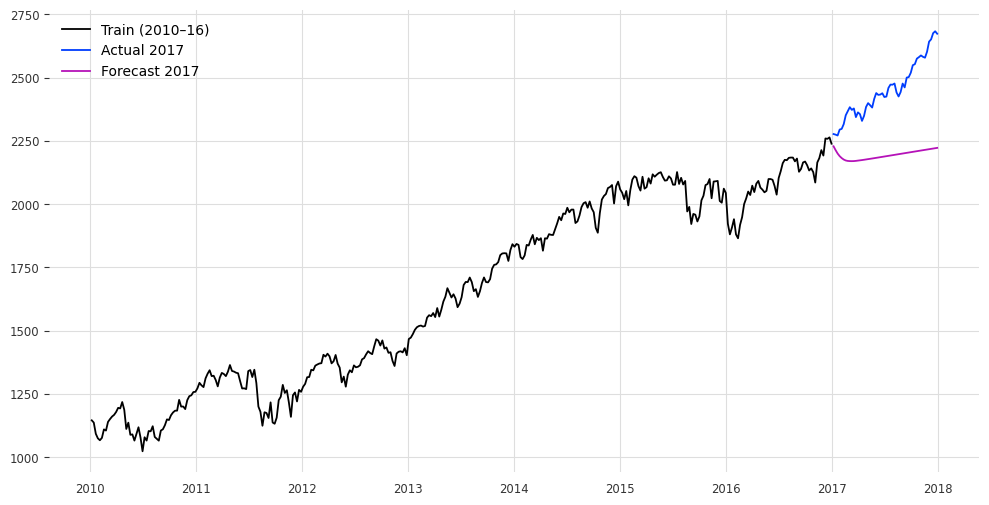

Test MAPE: 10.34%
Test MAE:  257.49
Test RMSE: 276.19


In [30]:
# Plot & metrics
import matplotlib.pyplot as plt
from darts.metrics import mae, rmse

plt.figure(figsize=(12,6))
plt.plot(train_ts.time_index, train_ts.values(), label="Train (2010–16)")
plt.plot(test_ts.time_index, test_ts.values(), label="Actual 2017")
plt.plot(forecast.time_index, forecast.values(), label="Forecast 2017")
plt.legend(); plt.show()

print(f"Test MAPE: {mape(test_ts, forecast):.2f}%")
print(f"Test MAE:  {mae(test_ts, forecast):.2f}")
print(f"Test RMSE: {rmse(test_ts, forecast):.2f}")